In [1]:
%load_ext tensorboard

<a id='intro'></a>
*To [Table of Contents](#toc)*
# Image Super Resolution
## Applied Machine Learning Systems 2
### University College London
#### Department of Electronic and Electrical Engineering
**Student Number:** $20167036$

<img src="./imgs/squirrels.png" alt="Drawing" style="height: 400px;"/>

This project focuses on generating *Super Resolution* (SR) images from *Low Resolution* (LR) ones using deep learning techniques. <br>
More specifically, the project aims at developing and evaluating deep learning models of various architectures for solving the [NTIRE2017 challenge](https://data.vision.ee.ethz.ch/cvl/ntire17/#challenge).

The datasets used for training and evaluating the models may be accessed from the [DIV2K Dataset Website](https://data.vision.ee.ethz.ch/cvl/DIV2K/) 

<a id='toc'></a>
## Table of Contents:
0. [Introduction](#intro)
1. [Loading Data](#load) 
2. [Data Visualisation and Pre-Processing](#pre-processing)
3. [Construct Models](#construct) 
4. [Model Training](#training)
5. [Performance Evaluation](#evaluate)
6. [Credits](#credits)



<a id='load'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/load.png" alt="Drawing" style="height: 80px;"/>
# 1. Loading Data

I'll now import some core data science and image manipulation libraries, as well as loading modules I've constructed myself to provide for a graphical user interface. 

**Note!** Much of this code will likely be modularised before turning in project.

In [2]:
# Import some core data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image manipulation modules
from PIL import Image

# File system modules
import os
import sys

# Navigate up one directory as notebook is in ./Notebooks directory
os.chdir('..')

# Import some homemade modules
from Modules import user_interface as ui

Define a function for loading images

In [3]:
def loadImages(directory, file_extension='.png', loading_message = 'Loading images...', num_imgs = None):
    
    # List container to hold image arrays
    images = []
    
    # Generate a sorted list of filenames for all images found in directory
    imgFiles = sorted([filename for filename in os.listdir(directory) if file_extension in filename])
    
    # Number of images to load counting from 0
    numImgs  = len(imgFiles) - 1 
    
    # Load image files from directory
    for i,filename in enumerate(imgFiles):
        
        img = Image.open(directory + filename) # Open image with Pillow function
        images.append(np.asarray(img))         # Append to image list as a numpy array
        
        # Print loading progress on every tenth and last image
        if not i % 10 or not i % numImgs:
            
            # Use print progress function from homemade user-interface module
            ui.print_progress(iteration = i,
                              total     = numImgs,
                              message   = loading_message)
            
        # Stop if number of images to load is reached, num_imgs set to None by default so will load all from dir
        if i == num_imgs:
            break
    
    # Return the loaded images
    return images

Load images, following is the directory structure:

```
Datasets
    > DIV2K_train_HR
    > DIV2K_train_LR_bicubic
        > X2
        > X3
        > X4
    > DIV2K_train_LR_unknown
        > X2
        > X3
        > X4
    > DIV2K_valid_HR
    > DIV2K_valid_LR_bicubic        
        > X2
        > X3
        > X4
    > DIV2K_valid_LR_unknown
        > X2
        > X3
        > X4
```

Let's get to it:

In [ ]:
load_2_ram = ui.yes_no_menu('Do you want to load the DIV2K Dataset to RAM (>10 GB)? (y/n)')

if load_2_ram:
    print('-'*80+'\n    I M P O R T I N G   L O W   R E S O L U T I O N   I M A G E   D A T A    \n'+'-'*80)

    # Bi-cubic x2 downscaled  images
    x2_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X2/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x2] Bi-Cubic Downsampled Training Images') 
    x2_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X2/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x2] Bi-Cubic Downsampled Testing Images ')

    # Bi-cubic x3 downscaled  images
    x3_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X3/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x3] Bi-Cubic Downsampled Training Images') 
    x3_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X3/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x3] Bi-Cubic Downsampled Testing Images ')

    # Bi-cubic x4 downscaled  images
    x4_bc_train = loadImages(directory       = './Datasets/DIV2K_train_LR_bicubic/X4/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x4] Bi-Cubic Downsampled Training Images') 
    x4_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X4/',
                             file_extension  = '.png',
                             loading_message = 'Loading [x4] Bi-Cubic Downsampled Testing Images ')

    print('-'*80+'\n   I M P O R T I N G   H I G H   R E S O L U T I O N   I M A G E   D A T A   \n'+'-'*80)

    # Original high-res images
    y_train     = loadImages(directory       = './Datasets/DIV2K_train_HR/',
                             file_extension  = '.png',
                             loading_message = 'Loading High Resolution Training Images   \t')
    y_test      = loadImages(directory       = './Datasets/DIV2K_valid_HR/',
                             file_extension  = '.png',
                             loading_message = 'Loading High Resolution Testing Images    \t')

To be honest I don't think this is going to work very well once we start training our model 😂

<img src="./imgs/ram.png" alt="Drawing" style="height: 450px;"/>

With `10.3GB` of RAM consumed already...<br>
But let's at least keep this in memory to do some visualisation of the original data, clear the memory, and develop a new method, either loading data for each task, e.g. `x2 bicubic` + `originals`, then `x3 bicubic` + `originals`, etc. or by using generators as suggested in: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/ 

I'll wrap this segment with a `(yes/no)` menu so we don't have to spend time loading this everytime we run the notebook.

**Update:** Well no the `keras generator` method actually looks like it won't work as it assumes same size images, I'll instead probably be making use of functions from `idealo's` implementation on `Github` https://github.com/idealo/image-super-resolution for interfacing with the `DIV2K` dataset. More on this in the [Model Training](#training) section.

<a id='pre-processing'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/visualisation.png" alt="Drawing" style="height: 100px;"/>
# 2. Data Visualisation and Pre-Processing

Use `gridspec` to create custom layouts for `subplots` and then draw frames on low-resolution images using `matplotlib.patches` to display varying image quality.

In [ ]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

In [ ]:
if load_2_ram:
    # Rectangle no. 1 to draw on original image
    patch1 = {'x' : 1100,
              'y' : 250,
              'w' : 250,
              'h' : 250}

    # Rectangle no. 2 to draw on original image
    patch2 = {'x' : 1600,
              'y' : 800,
              'w' : 250,
              'h' : 250}

    # Rectangles to draw on downscaled images 
    patch3 = {key: int(val/2) for key,val in patch1.items()} # x2
    patch4 = {key: int(val/2) for key,val in patch2.items()} # x2
    patch5 = {key: int(val/3) for key,val in patch1.items()} # x3
    patch6 = {key: int(val/3) for key,val in patch2.items()} # x3
    patch7 = {key: int(val/4) for key,val in patch1.items()} # x4
    patch8 = {key: int(val/4) for key,val in patch2.items()} # x4

    # Make an iterable from the patch definitions created
    allPatches = [patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8]
    colours    = ['r','b','r','b','r','b','r','b']
    frames     = []

    # Create frame objects from patch coordinates
    for patch,colour in zip(allPatches,colours):
        frame = patches.Rectangle(xy        = (patch['x'],patch['y']),
                                  width     = patch['w'],
                                  height    = patch['h'],
                                  edgecolor = colour,
                                  fill      = False,
                                  linewidth = 2)
        frames.append(frame)

This is going to call for some very unrefined verbose...

In [ ]:
if load_2_ram:
    fig  = plt.figure(constrained_layout=True, figsize = (16,8), dpi = 400)
    gs   = fig.add_gridspec(nrows=4, ncols=6)

    # Upper left quartile 1 - big 2 - upper small 3 - lower small
    ax1  = fig.add_subplot(gs[0:2, 0:2])
    ax2  = fig.add_subplot(gs[0, 2])
    ax3  = fig.add_subplot(gs[1, 2])
    ax1.set_title('Original')

    # Lower left quartile
    ax4  = fig.add_subplot(gs[2:4, 0:2])
    ax5  = fig.add_subplot(gs[2, 2])
    ax6  = fig.add_subplot(gs[3, 2])
    ax4.set_title('[x2] Downsampled')

    # Upper right quartile
    ax7  = fig.add_subplot(gs[0:2, 3:5])
    ax8  = fig.add_subplot(gs[0, 5])
    ax9  = fig.add_subplot(gs[1, 5])
    ax7.set_title('[x4] Downsampled')

    # Lower right quartile
    ax10 = fig.add_subplot(gs[2:4, 3:5])
    ax11 = fig.add_subplot(gs[2, 5])
    ax12 = fig.add_subplot(gs[3, 5])
    ax10.set_title('[x3] Downsampled')

    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    num_img = 139

    ax1.imshow(y_train[num_img])
    ax1.add_patch(frames[0])
    ax1.add_patch(frames[1])
    ax2.imshow(y_train[num_img][patch1['y']:(patch1['y']+patch1['h']),patch1['x']:(patch1['x']+patch1['w'])])
    ax3.imshow(y_train[num_img][patch2['y']:(patch2['y']+patch2['h']),patch2['x']:(patch2['x']+patch2['w'])])

    ax4.imshow(x2_bc_train[num_img])
    ax4.add_patch(frames[2])
    ax4.add_patch(frames[3])
    ax5.imshow(x2_bc_train[num_img][patch3['y']:(patch3['y']+patch3['h']),patch3['x']:(patch3['x']+patch3['w'])])
    ax6.imshow(x2_bc_train[num_img][patch4['y']:(patch4['y']+patch4['h']),patch4['x']:(patch4['x']+patch4['w'])])

    ax7.imshow(x4_bc_train[num_img])
    ax7.add_patch(frames[6])
    ax7.add_patch(frames[7])
    ax8.imshow(x4_bc_train[num_img][patch7['y']:(patch7['y']+patch7['h']),patch7['x']:(patch7['x']+patch7['w'])])
    ax9.imshow(x4_bc_train[num_img][patch8['y']:(patch8['y']+patch8['h']),patch8['x']:(patch8['x']+patch8['w'])])

    ax10.imshow(x3_bc_train[num_img])
    ax10.add_patch(frames[4])
    ax10.add_patch(frames[5])
    ax11.imshow(x3_bc_train[num_img][patch5['y']:(patch5['y']+patch5['h']),patch5['x']:(patch5['x']+patch5['w'])])
    ax12.imshow(x3_bc_train[num_img][patch6['y']:(patch6['y']+patch6['h']),patch6['x']:(patch6['x']+patch6['w'])])

    plt.suptitle('Bicubically Downscaled Image Resolution Comparison')
    plt.show()

<a id='construct'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/construction.png" alt="Drawing" style="height: 75px;"/>
# 3. Construct Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

def SRCNN(n_convs=5):
   
    SRCNN = Sequential()
    
    # Changed input shape to (None, None, 3)
    SRCNN.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu',input_shape=(None,None,3)))    
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu'))
    SRCNN.add(Conv2DTranspose(filters=3, kernel_size=(2,2), strides=(2,2), padding='same', activation=None))
    
    SRCNN.compile(optimizer=Adam(lr=1e-4), loss='mean_squared_error',metrics=['mean_squared_error'])
    SRCNN.build()
    SRCNN.summary()
    
    return SRCNN

In [ ]:
srcnn = SRCNN()

https://keras.io/api/metrics/

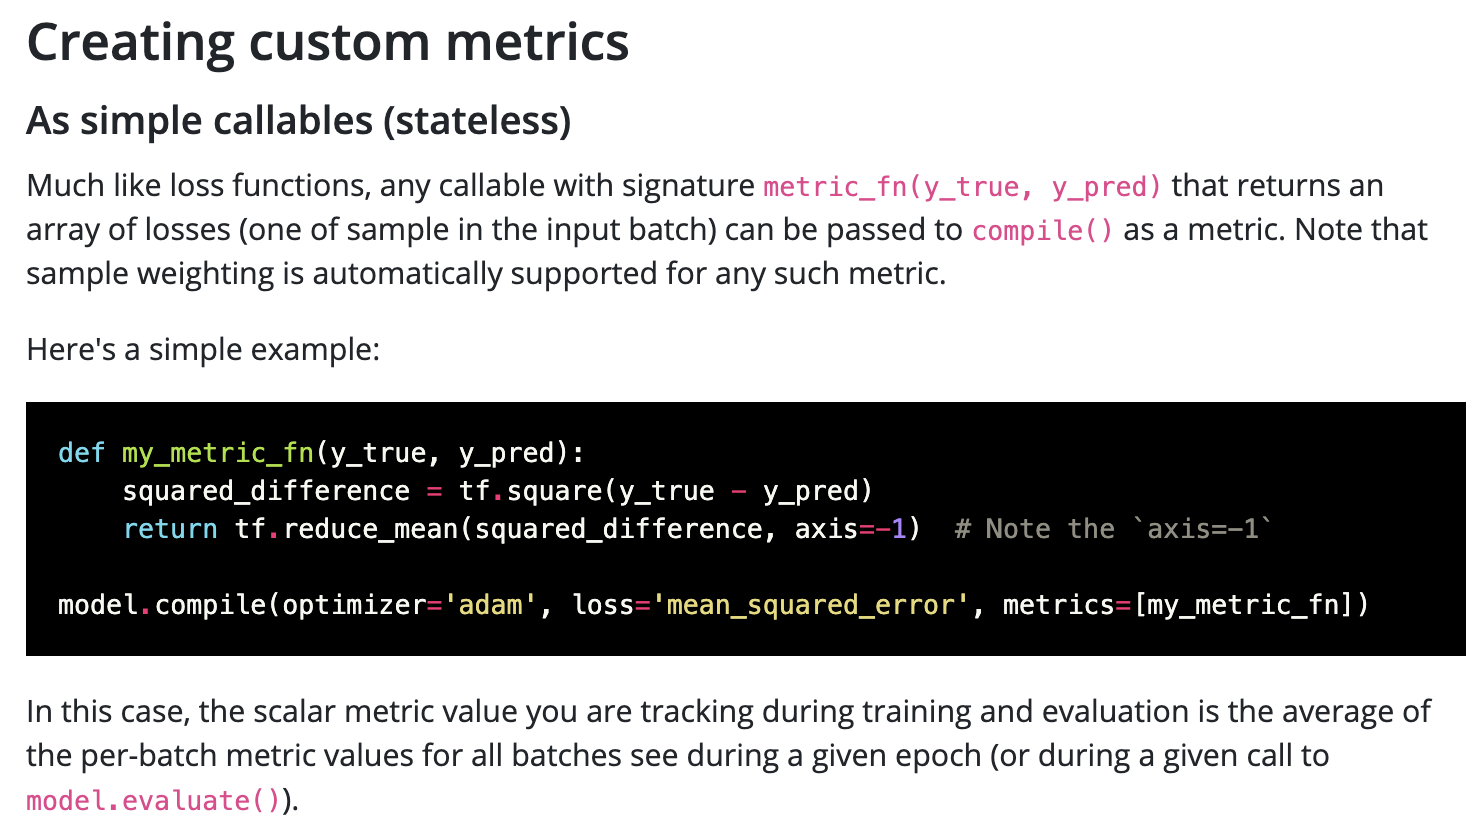

https://github.com/MarkPrecursor/SRCNN-keras/blob/master/main.py

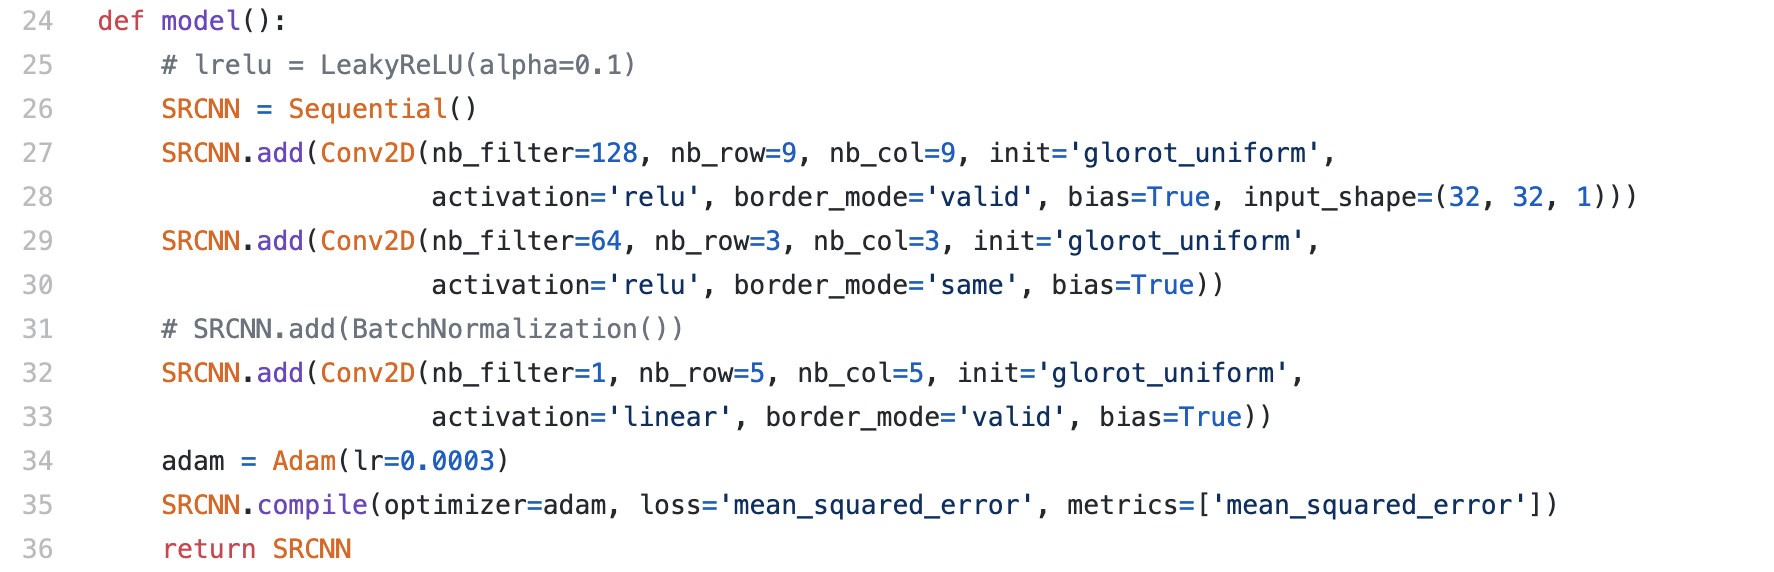

<a id='training'></a>
*Back to [Table of Contents](#toc)*
<img src="./imgs/training.png" alt="Drawing" style="height: 90px;"/>
# 4. Model Training

## 4.1 Getting Acquainted with the Data Handler

So - to deal with data handling for the training process, it became obvious as per section [Loading Data](#load) that we'd face some real issues if we were to load all of the images into memory, as the bicubic datasets and corresponding high-resolution images are some 10.3 GB in size. 

For our training to be successful, we'll need to devise a new data handling strategy.

Looking into the winning paper of the NTIRE17 challenge, titled *[Enhanced Deep Residual Networks for Single Image Super-Resolution](https://arxiv.org/pdf/1707.02921.pdf)* by *B. Lim, S. Son, H. Kim, S. Nah & K.M. Lee*, it soon became apparent that full sized images would not be needed to train the model.

Instead, the model can be trained using only patches from the low resolution images, with the corresponding high-resolution image patches, as stated in Section 4.2 of the paper:

>*For training, we use the RGB input patches of size $48\times48$ from LR image with the corresponding HR patches.*

and they go on to further describe the training process as follows:

>*We augment the training data with random horizontal flips and $90°$ rotations. We pre-process all the images by subtracting the mean RGB value of the DIV2K dataset. We train our model with ADAM optimizer by setting $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-8}$. We set minibatch size as 16. The learning rate is initialized as $10^{−4}$ and halved at every $2 \times 10^5$ minibatch updates.*

To design an image patch generator for the training would require some heavy lifting programming. Seeing as I'm allergic to manual labour (🙃), I instead searched for open source code that used the `DIV2K` dataset and soon arrived at [idealo's GitHub](https://idealo.github.io/image-super-resolution/), where they've built an API for image super resolution. Ofcourse, I want the challenge of designing and constructing my own model so I won't be using any of that in this project, but I'd rather spend my time on something more meaningful than crafting a novel data image generator (seeing as the `keras` one won't be of much help).

**Warning!** The next line installs the `ISR` API which will upgrade `TensorFlow` to `v2.0.0`

So reading through the source code, we can start figuring out how to go about using these objects, let's begin by creating a datahandler, it's contained in the `./utils` module:

In [ ]:
# Import the datahandler class from the .utils module
from ISR.utils import datahandler as ISR_dh

# Define parameters for the training task, let's use 48x48 patches for the x2 downscaled images
lr_patch_size = 48
scale         = 2

# We now create a datahandler for the training, and point it to the location of the LR and HR images
datahandler = ISR_dh.DataHandler(lr_dir = './Datasets/DIV2K_train_LR_bicubic/X2/',
                                 hr_dir = './Datasets/DIV2K_train_HR/',
                                 patch_size = lr_patch_size, 
                                 scale = scale,
                                 n_validation_samples = 1)

Let's then test the datahandler by generating a batch using the `.get_batch` method.<br>
For this, we pass the datahandler the number of images we wish to include in our batch, **AND** a `flatness` criterion which should take a value in the interval $\mathbb{R} \in [0,1]$, which states how *feature less* the image patches are allowed to be. <br>
If we pass $0$, it means any image patch will be accepted, suggesting we could get e.g. an all black patch. <br>
This likely will interfer with our training process and slow down any learning, so let's set a reasonable threshold of 0.1, let's see what this looks like below:

In [ ]:
# Get batch
batch = datahandler.get_batch(batch_size = 4, flatness = .1)

# Visualise the result - .get_batch returns a dictionary {'lr':np.arrays[batch_size], 'hr':np.arrays[batch_size]}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

ax[0].imshow(batch['lr'][0])
ax[0].set_title('Random low-resolution patch')
ax[1].set_title('Corresponding high-resolution patch')
ax[1].imshow(batch['hr'][0])

for plot in ax.ravel():
    plot.set_xticks([])
    plot.set_yticks([])

plt.suptitle('Verifying idealo/ISR DataHandler - Generating Image Patches for Training')
plt.tight_layout()
plt.show()

# Patch flatness: 
print('Patch flatness: {}'.format(max(np.std(batch['lr'][0], axis=0).mean(), np.std(batch['lr'][0], axis=1).mean())))

# Print some shape info
print('LR imageset shape: {}'.format(batch['lr'].shape))
print('HR imageset shape: {}'.format(batch['hr'].shape))
print('Where: (batch_size, width, height, n_channels)')

It seems that the `flatness` parameter is incremented from `0.0` to `0.15` when used in a notebook example by it's designers: 

https://github.com/idealo/image-super-resolution/blob/master/notebooks/ISR_Traininig_Tutorial.ipynb

Search for `flatness`.<br>
**Note** I'll disect this further once we get closer to start training the model and see if we should do the same.

Now bare in mind, this `DataHandler` not only generates these random patches from the images, but also performs augmentation on them. <br>
I'll now verify that this is infact being performed, the augmentation performed is in the form of rotations and flips.

In [ ]:
val_batch = datahandler.get_validation_batches(batch_size = 1)

In [ ]:
# Check the .img_list property of the data handler, it should hold the validation image filenames
datahandler.img_list

Okay this makes sense - let's plot this image

In [ ]:
# Visualise the result - .get_val_batch returns a dictionary {'lr':np.arrays[val_batch_size], 'hr':np.arrays[val_batch_size]}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

ax[0].imshow(val_batch[0]['lr'][0])
ax[0].set_title('Low-resolution patch from: {}'.format(datahandler.img_list['lr'][0]))
ax[1].set_title('Corresponding high-resolution patch')
ax[1].imshow(val_batch[0]['hr'][0])

for plot in ax.ravel():
    plot.set_xticks([])
    plot.set_yticks([])

plt.suptitle('Verifying idealo/ISR DataHandler - Generating Image Patches for Training')
plt.tight_layout()
plt.show()

# Patch flatness: 
print('Patch flatness: {}'.format(max(np.std(val_batch[0]['lr'][0], axis=0).mean(), np.std(val_batch[0]['lr'][0], axis=1).mean())))

# Print some shape info
print('LR imageset shape: {}'.format(val_batch[0]['lr'].shape))
print('HR imageset shape: {}'.format(val_batch[0]['hr'].shape))
print('Where: (val_batch_size, width, height, n_channels)')

Okay - by comparing with the original image, it's evident that this is a transformed patch from the original image:

![img](./imgs/0049.png)
![img](./imgs/patch_transformed.png)

## 4.2 Metrics (MSE - PSNR - SSIM)

PSNR is most easily defined via the mean squared error ( $MSE$ ). <br>
Given a noise-free $m \times n$ monochrome image $I$ and its noisy approximation $K$, $MSE$ is defined as:

\begin{equation}
MSE = \frac{1}{m n} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \left[ I(i,j) - K(i,j) \right]^2
\end{equation}

The PSNR (in $dB$) is defined as:

\begin{equation}
    PSNR = 10\cdot \log_{10} \left( \frac{MAX_{I}^{2}}{MSE} \right) = 20 \cdot \log_{10}(MAX_I) - 10 \cdot \log_{10}(MSE)
\end{equation}

Where $MAX_I$ is the maximum pixel value, often an integer in $\mathbb{Z} \in [0,255]$, but our pixelvalues have been normalised to $\mathbb{R} \in [0,1]$, but this sort of normalisation tends to provide smoother gradient descent.

In [ ]:
def MSE(I, K):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    
    Return: 
        Mean Squared Error of I and K
    """
    return np.mean(np.square(I - K))

In [ ]:
def PSNR(I, K, MAX_I=1.0):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    MAX_I = Maximum image pixelvalue e.g. 255 or 1
    
    Return: 
        Peak Signal Noise Ratio
    """
    return 20*np.log(MAX_I) - 10*np.log(MSE(I,K))

While simple to implement, $MSE$ or $PSNR$, is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account - [scikit-image](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html)

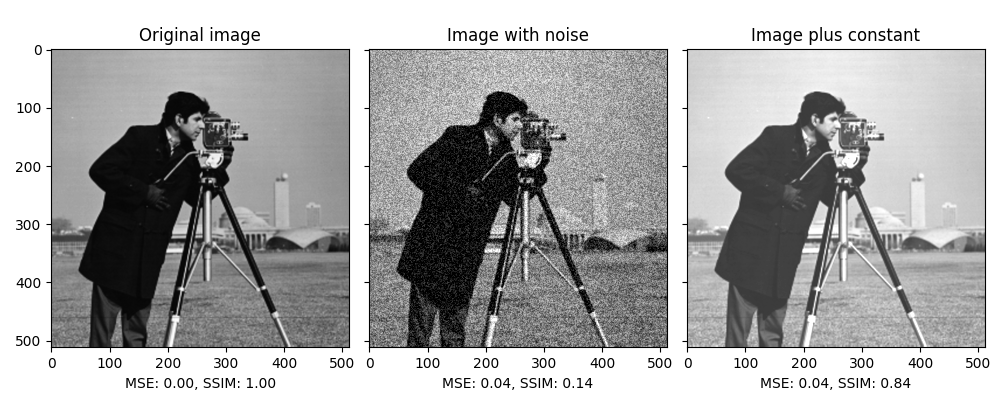

In [ ]:
from skimage.metrics import structural_similarity as SSIM

Let's test these functions out.<br>
We know the LR images have been downscaled bicubically, so we can try to upscale them in the same manner, and compare with the original, checking out the resulting metrics.

In [ ]:
# Open-CV's got a function for resizing with bicubic interpolation
import cv2

# Get the images
hi_res   = batch['hr'][0]
low_res  = batch['lr'][0]

# Upscale the low-res one 
upscaled = cv2.resize(low_res, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)

# Visualise
plt.imshow(upscaled)

In [ ]:
print('MSE:  {:.5f}'.format(MSE(hi_res, upscaled)))
print('PSNR: {:.1f} db'.format(PSNR(hi_res, upscaled)))
print('SSIM: {:.5f}'.format(SSIM(hi_res, upscaled, multichannel=True)))

Let's now build one function that wraps these evaluation metrics in a single container

In [ ]:
def evaluate(I,K):
    """
    I     = Original RGB image  I(i,j,k)
    K     = Reference RGB image K(i,j,k)
    
    Return: 
        Dictionary of metrics, MSE, PSNR and SSIM
    """
    
    metrics = {'MSE':MSE(I,K),
               'PSNR':PSNR(I,K),
               'SSIM':SSIM(I,K,multichannel=True)}
    return metrics

In [ ]:
evaluate(hi_res, upscaled)

Great, our metrics are in order.

## 4.3 Training the Model

Finally we're ready

In [ ]:
# Import the datahandler class from the .utils module
from ISR.utils import datahandler as ISR_dh

# Define parameters for the training task, let's use 48x48 patches for the x2 downscaled images
lr_patch_size = 48
scale         = 2
batch_size    = 32

# We now create a datahandler for the training, and point it to the location of the LR and HR images
datahandler = ISR_dh.DataHandler(lr_dir = './Datasets/DIV2K_train_LR_bicubic/X2/',
                                 hr_dir = './Datasets/DIV2K_train_HR/',
                                 patch_size = lr_patch_size, 
                                 scale = scale,
                                 n_validation_samples = 50)

In [ ]:
validation_set = datahandler.get_validation_set(batch_size = batch_size)

In [ ]:
x_val = validation_set['lr']
y_val = [validation_set['hr']]

In [ ]:
x2_bc_test  = loadImages(directory       = './Datasets/DIV2K_valid_LR_bicubic/X2/',
                         file_extension  = '.png',
                         loading_message = 'Loading [x2] Bi-Cubic Downsampled Testing Images ',
                         num_imgs        = 1)
y_test      = loadImages(directory       = './Datasets/DIV2K_valid_HR/',
                         file_extension  = '.png',
                         loading_message = 'Loading High Resolution Testing Images    \t',
                         num_imgs        = 1)

In [ ]:
h,w,ch = x2_bc_test[0].shape
x2_bc_test[0] = np.reshape(x2_bc_test[0], (1,h,w,ch))
x2_bc_test[0] = x2_bc_test[0] / 255

In [ ]:
plt.imshow(x2_bc_test[0][0])

In [ ]:
y_pred = srcnn.predict(x2_bc_test[0])

In [ ]:
plt.imshow(y_pred[0])

In [ ]:
from time import time
from tensorflow.keras.callbacks import TensorBoard

# Transform train_on_batch return value
# to dict expected by on_batch_end callback
def named_logs(model, logs):
    result = {}
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    return result

# Training settings
total_epochs    = 40
steps_per_epoch = batch_size

for epoch in range(total_epochs):
    
    tensorboard = TensorBoard(log_dir='./logs/',
                              histogram_freq=0, 
                              write_graph = True)
    
    tensorboard.set_model(srcnn)
    
    print('Epoch: {e}/{tot_e}'.format(e=epoch,tot_e=total_epochs))
    
    epoch_start = time()
    
    for step in range(steps_per_epoch):
        
        batch = datahandler.get_batch(batch_size = batch_size, flatness = .1)
        
        x_train = batch['lr']
        y_train = batch['hr']
            
        logs = srcnn.train_on_batch(x = x_train,
                                    y = y_train)
    
    tensorboard.on_epoch_end(epoch, named_logs(srcnn, logs))
    validation_losses = srcnn.evaluate(x_val, 
                                       y_val, 
                                       batch_size=batch_size)
    tensorboard.on_epoch_end(epoch, validation_losses)
tensorboard.on_train_end(None)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {'./logs/'}

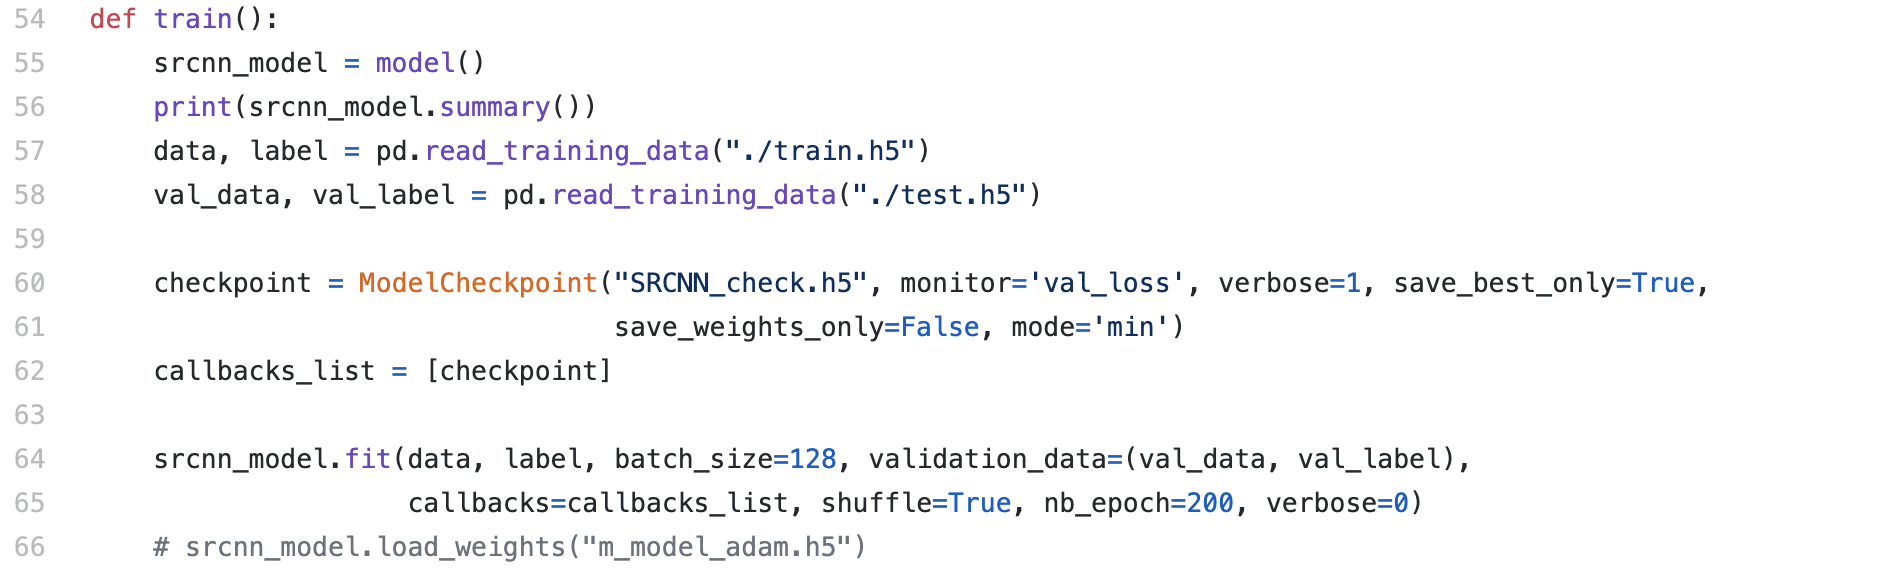

<a id='evaluate'></a>
*Back to [Table of Contents](#toc)*
# 5. Performance Evaluation

In [ ]:
# Update the flatness threshold, so that it's maxed at 0.15 once 2/3 of the training session are completed
            if flatness_threshold <= 0.15:
                flatness_threshold += (0.15/(2*total_epochs/3))

<a id='credits'></a>
*Back to [Table of Contents](#toc)*
# 6. Credits


Chapter Title Icons: <a href="www.flaticon.com">Flaticon.com</a>. <br>
This notebook has been designed using resources from <a href="www.flaticon.com">Flaticon.com </a>

In [ ]:
flatness  = 0
epochs    = 100
steps_per = 100

lr_scheduler = {'initial_value'   : 1e-4,
                'decay_factor'    : 0.5 ,
                'minimum'         : 1e-7,
                'update_interval' : 5    }

lr = lr_scheduler['initial_value']

def lr_decay(learning_rate, decay_factor, minimum,**kwargs):
    learning_rate *= decay_factor
    if learning_rate <= minimum:
        learning_rate = minimum
    return learning_rate

for i in range(epochs):
    
    if flatness < 0.15:
        flatness += (0.15/(2*epochs/3))
    else:
        flatness = 0.15
    
    for j in range(steps_per):
        pass
    print("Epoch: \t {} \t Flatness: {:.20f}".format(i,flatness))
    
    if not i % lr_scheduler['update_interval'] and (i) :
        lr = lr_decay(lr,**lr_scheduler)
        print("Step:\t {} \t Learning Rate: {}".format(i,lr))
    